### Description：
> 在数据预处理部分，已经把所有的数据统一化特征了，现在的数据都是一样的维度大小，但是存在的问题是缺失值太多， 现在我想先简单的进行下一步，模型部分， 先建立简单的模型跑跑试试, 但还是有一些工作要做
>> * 1. 缺失值的问题，这里我打算直接用填充的方式解决， 两种填充方式： 零填充，简单暴力，并且我目前觉得挺好的一种方式。 均值或者中位数填充， 这个填充的话要分好正负样本才行， 我先试试第一种填充方式
>> * 2. 数据类型的问题，目前的数据都是object， 所以需要先进行数据的转换，并且探测器类型那块还有字符，需要编码LabelEncoder
>> * 2. 特征的问题， 至于深度那块的特征实在是太多，我想用自动编码器进行降维
>> * 3. 这样处理完之后，合成新的数据集，然后就进行划分，先采用K近邻跑一遍试试

In [36]:
"""导入包"""
import numpy as np
import pandas as pd

from keras.models import Model #泛型模型
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# 模型选择
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# 模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# 模型度量函数
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [37]:
"""导入数据"""
data = pd.read_csv("data1.csv")

In [38]:
"""处理缺失值，先采用简单的0填充"""
data.head(5)
data = data.fillna(0)

# print(data.isnull().sum())
print(data.shape)
data.head(5)

(22902, 2929)


,time,latitude,longitude,instrument,temperature0.0,temperature20.0,temperature250.0,temperature70.0,temperature140.0,temperature155.0,...,salinity1516.0,temperature1036.0,salinity1036.0,temperature863.0,salinity863.0,temperature943.0,salinity943.0,temperature967.0,salinity967.0,label
0,23806.38,1.200,139.100,1,29.9,30.0,0.0,28.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,23806.42,1.783,137.500,1,30.1,30.1,0.0,29.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,23806.50,1.883,137.867,1,28.9,28.9,0.0,27.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,23806.58,2.083,137.300,1,29.0,29.0,0.0,28.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,23806.67,2.283,137.183,1,28.9,28.9,0.0,26.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [39]:
#### """查看一下数据类型，把instrument转换成LabelEncoder编码"""
# print(data.dtypes)
tran = data['instrument']
tran = tran.astype(np.string_)
data['instrument'] = tran

le = preprocessing.LabelEncoder()
le.fit(data['instrument'].unique())
data['instrument'] = le.transform(data['instrument'])
# print(data['instrument'])
print(data['instrument'].value_counts())

8    12840
1     3347
5     2395
0     1670
3     1654
7      477
2      372
4      108
9       34
6        5
Name: instrument, dtype: int64


In [40]:
"""查看data的数据类型，并且要进行编码器和解码器压缩特征"""
data.dtypes
data.head(5)

# 提取出sub_data，保存需哟啊的特征
sub_data = data.iloc[:, 0:4].copy()
# 获取需要压缩的列
deep = data.iloc[:, 4:-1].copy()

In [5]:
value = deep.values
print(value.shape)

(22902, 2924)


In [41]:
"""把数据进行标准化"""
scaler = StandardScaler()
values = scaler.fit_transform(value)

In [42]:
"""自编码器模型"""

# 压缩特征维度至2维
encoding_dim = 5
 
# this is our input placeholder
input_data = Input(shape=(2924,))
 
# 编码层
encoded = Dense(128, activation='relu')(input_data)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)
 
# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(2924, activation='tanh')(decoded)
 
# 构建自编码模型
autoencoder = Model(inputs=input_data, outputs=decoded)
 
# 构建编码模型
encoder = Model(inputs=input_data, outputs=encoder_output)
 
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
 
# training
autoencoder.fit(values, values, epochs=20, batch_size=256, shuffle=True)


Epoch 1/20
22902/22902 [==============================] - 8s 366us/step - loss: 0.9092
Epoch 2/20
22902/22902 [==============================] - 7s 320us/step - loss: 0.8882
Epoch 3/20
22902/22902 [==============================] - 7s 311us/step - loss: 0.8820
Epoch 4/20
22902/22902 [==============================] - 6s 247us/step - loss: 0.8810
Epoch 5/20
22902/22902 [==============================] - 5s 222us/step - loss: 0.8750
Epoch 6/20
22902/22902 [==============================] - 5s 222us/step - loss: 0.8737
Epoch 7/20
22902/22902 [==============================] - 5s 223us/step - loss: 0.8728
Epoch 8/20
22902/22902 [==============================] - 5s 224us/step - loss: 0.8718
Epoch 9/20
22902/22902 [==============================] - 5s 223us/step - loss: 0.8708
Epoch 10/20
22902/22902 [==============================] - 5s 223us/step - loss: 0.8700
Epoch 11/20
22902/22902 [==============================] - 5s 223us/step - loss: 0.8688
Epoch 12/20
22902/22902 [================

In [43]:
# plotting
encoded_data = encoder.predict(values)
print(encoded_data.shape)

(22902, 5)


In [44]:
# new_feature_data = pd.DataFrame(encoded_data, columns = ['deep1', 'deep2'])
sub_data1 = pd.DataFrame(encoded_data, columns=['deep'+ str(i) for i in range(encoding_dim)])
print(sub_data1.shape)

(22902, 5)


In [45]:
"""下面进行数据的合并"""
newdata = pd.concat([sub_data, sub_data1], axis=1)
print(newdata.shape)

(22902, 9)


In [25]:
"""查看newdata"""
newdata.head(5)

,time,latitude,longitude,instrument,deep0,deep1,deep2,deep3,deep4
0,23806.38,1.200,139.100,0,-1.263606,2.414915,2.106735,-2.174347,-11.102189
1,23806.42,1.783,137.500,0,-1.271358,2.432063,2.111157,-2.181359,-11.154698
2,23806.50,1.883,137.867,0,-1.208363,2.282415,2.080159,-2.148557,-10.749419
3,23806.58,2.083,137.300,0,-1.221684,2.319156,2.085422,-2.154826,-10.839140
4,23806.67,2.283,137.183,0,-1.201099,2.265702,2.083145,-2.149527,-10.727961


In [46]:
# 标准化前三列的数据
newdata.iloc[:,0:3] = scaler.fit_transform(newdata.iloc[:, 0:3])

In [27]:
newdata.head(5)

,time,latitude,longitude,instrument,deep0,deep1,deep2,deep3,deep4
0,-2.832190,-1.110975,1.167391,0,-1.263606,2.414915,2.106735,-2.174347,-11.102189
1,-2.832180,-0.912803,0.576045,0,-1.271358,2.432063,2.111157,-2.181359,-11.154698
2,-2.832159,-0.878811,0.711685,0,-1.208363,2.282415,2.080159,-2.148557,-10.749419
3,-2.832139,-0.810828,0.502127,0,-1.221684,2.319156,2.085422,-2.154826,-10.839140
4,-2.832115,-0.742844,0.458885,0,-1.201099,2.265702,2.083145,-2.149527,-10.727961


###  创建数据集和模型
> 通过上面的处理，就有了成形的数据，下面就是创建数据集和模型，然后进行选择

In [47]:
"""获取数据集，并且分出测试集"""
X = newdata.copy().values
Y = data['label'].values

print(X.shape)
print(Y.shape)
print(data['label'].value_counts())

"""由于不匹配，所有分割数据集的时候采用层次抽样的方式"""
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_index, test_index in ss.split(X, Y):
    print(train_index, test_index)
    train_set_x = X[train_index]
    train_set_y = Y[train_index]
    test_set_x = X[test_index]
    test_set_y = Y[test_index]

(22902, 9)
(22902,)
1    22620
0      282
Name: label, dtype: int64
[19981 20192 14712 ... 16155   864 11307] [10120 22778  5491 ...  8580 12656  9331]


In [48]:
print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

(18321, 9)
(18321,)
(4581, 9)
(4581,)


KNN: 0.989 (0.002)
CART: 0.982 (0.004)
SVM: 0.988 (0.003)
NB: 0.961 (0.006)
Ada: 0.988 (0.003)
Xgb: 0.989 (0.003)


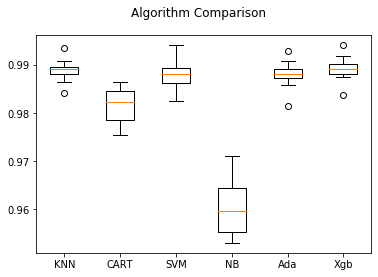

In [49]:
"""创建各种模型"""
num_folds = 10
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed)
models = {}
# models['LR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['SVM'] = SVC()
models['NB'] = GaussianNB()
models['Ada'] = AdaBoostClassifier()
# models['Xgb'] = XGBClassifier(learning_rate=0.1,
#                               n_estimators=1000,         # 树的个数--1000棵树建立xgboostmax_depth=6,              
#                               max_depth=6,               # 树的深度
#                               min_child_weight = 1,      # 叶子节点最小权重
#                               gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                               subsample=0.8,             # 随机选择80%样本建立决策树
#                               colsample_btree=0.8,       # 随机选择80%特征建立决策树
#                               scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                               random_state=27            # 随机数)
#                              )
models['Xgb'] = XGBClassifier()
results = []

for name in models:
    result = cross_val_score(models[name], train_set_x, train_set_y, cv=kfold)
    results.append(result)
    msg = ('%s: %.3f (%.3f)' % (name, result.mean(), result.std()))
    print(msg)
    
# 图表展示
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()    

In [35]:
"""优化模型 - KNN调参"""
# 调参改进算法 --- KNN
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优: %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])

for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param)) 

最优: 0.9887560722667976 使用 {'n_neighbors': 7}
0.985809 (0.001923) with {'n_neighbors': 1}
0.988101 (0.001757) with {'n_neighbors': 3}
0.987937 (0.002149) with {'n_neighbors': 5}
0.988756 (0.002468) with {'n_neighbors': 7}
0.988319 (0.002643) with {'n_neighbors': 9}
0.988483 (0.002862) with {'n_neighbors': 11}
0.988538 (0.002762) with {'n_neighbors': 13}
0.988592 (0.002810) with {'n_neighbors': 15}
0.988592 (0.002810) with {'n_neighbors': 17}
0.988592 (0.002810) with {'n_neighbors': 19}
0.988265 (0.002860) with {'n_neighbors': 21}


In [ ]:
"""优化模型 - SVM调参"""
# 支持向量机有两个重要的参数：  C（惩罚系数）默认1.0 和kernel（径向基函数） 默认rbf
param_grid = {}
param_grid['C'] = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
param_grid['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
# 注意： 这里的kernel参数不要有precomputed  , 否则会报错
"""
ValueError: X should be a square kernel matrix

    解决：从参数空间中删除“预先计算”.
        kernel =’precomputed’只能在传递表示样本的成对相似性的(n_samples,n_samples)数据矩阵时使用,
        而不是传统的(n_samples,n_features)矩形数据矩阵.
"""

model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优： %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param))

In [23]:
"""AdaBoost调参"""
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优： %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))

cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param))

最优： 0.9883739970525627 使用 {'n_estimators': 10}
0.988374 (0.002827) with {'n_estimators': 10}
0.988319 (0.002870) with {'n_estimators': 50}
0.988101 (0.002835) with {'n_estimators': 100}
0.987992 (0.002675) with {'n_estimators': 200}
0.987937 (0.002385) with {'n_estimators': 300}
0.987992 (0.002303) with {'n_estimators': 400}
0.987774 (0.002492) with {'n_estimators': 500}
0.987664 (0.002655) with {'n_estimators': 600}
0.987664 (0.003042) with {'n_estimators': 700}
0.987774 (0.002786) with {'n_estimators': 800}
0.987774 (0.002586) with {'n_estimators': 900}


###  确定最终的模型

In [54]:
# model =XGBClassifier(learning_rate=0.1,
#                      n_estimators=1000,         # 树的个数--1000棵树建立xgboostmax_depth=6,              
#                      max_depth=6,               # 树的深度
#                      min_child_weight = 1,      # 叶子节点最小权重
#                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                      subsample=0.8,             # 随机选择80%样本建立决策树
#                      colsample_btree=0.8,       # 随机选择80%特征建立决策树
#                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                      random_state=27            # 随机数)
#                     )

#model = AdaBoostClassifier(n_estimators=10)
model = KNeighborsClassifier(n_neighbors=7)
#model = XGBClassifier()

model.fit(X=train_set_x, y=train_set_y)

# 评估模型
predictions = model.predict(test_set_x)
print("accuracy_score\n",accuracy_score(test_set_y, predictions))
print("\nconfusion_matrix\n", pd.DataFrame(confusion_matrix(test_set_y, predictions),columns=np.unique(test_set_y), index=np.unique(test_set_y)))
print("\nclassification_report\n", classification_report(test_set_y, predictions))

accuracy_score
 0.9884304736956996

confusion_matrix
    0     1
0  9    47
1  6  4519

classification_report
               precision    recall  f1-score   support

           0       0.60      0.16      0.25        56
           1       0.99      1.00      0.99      4525

    accuracy                           0.99      4581
   macro avg       0.79      0.58      0.62      4581
weighted avg       0.98      0.99      0.99      4581

